# Introduction

## Lab2: Train a Convolutional Neural Network (CNN).

In this Lab session we will learn how to train a CNN from scratch for classifying MNIST digits.

In [1]:
# import necessary libraries
import torch
import torchvision
from torchvision import transforms as T
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

### Define LeNet

![network architecture](https://www.researchgate.net/profile/Lucijano-Berus/publication/329891470/figure/fig1/AS:707347647307776@1545656229128/Architecture-of-LeNet-5-a-Convolutional-Neural-Network-for-digits-digits-recognition-An.ppm)

Here we are going to define our first CNN which is **LeNet** in this case. This architecture has been introduced and is detailed in [this article](http://vision.stanford.edu/cs598_spring07/papers/Lecun98.pdf). To construct a LeNet we will be using some convolutional layers followed by some fully-connected layers. The convolutional layers can be simply defined using `torch.nn.Conv2d` module of `torch.nn` package. Details can be found [here](https://pytorch.org/docs/stable/nn.html#conv2d). Moreover, we will use pooling operation to reduce the size of convolutional feature maps. For this case we are going to use `torch.nn.functional.max_pool2d`. Details about maxpooling can be found [here](https://pytorch.org/docs/stable/nn.html#max-pool2d)

Differently from our previous Lab, we will use a Rectified Linear Units (ReLU) as activation function with the help of `torch.nn.functional.relu`, replacing `torch.nn.Sigmoid`. Details about ReLU can be found [here](https://pytorch.org/docs/stable/nn.html#id26).

In [2]:
device = "cuda" if torch.cuda.is_available else "cpu"

In [3]:
class LeNet(torch.nn.Module):
    
    def __init__(self):
        super(LeNet, self).__init__()

        
        self.conv_1 = torch.nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=2, device=device)
        self.conv_2 = torch.nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0, device=device)

        
        self.connected_1 = torch.nn.Linear(in_features=400, out_features=120, device=device)
        self.connected_2 = torch.nn.Linear(in_features=120, out_features=84, device=device)
        self.connected_3 = torch.nn.Linear(in_features=84, out_features=10, device=device)

    def forward(self, x):
        

        x = self.conv_1(x)                        
        x = torch.nn.functional.relu(x)
        x = torch.nn.functional.max_pool2d(x, 2)  

        x = self.conv_2(x)                        
        x = torch.nn.functional.relu(x)
        x = torch.nn.functional.max_pool2d(x, 2)  

        x = x.view(x.shape[0], -1)                

        x = self.connected_1(x)
        x = torch.nn.functional.relu(x)

        x = self.connected_2(x)
        x = torch.nn.functional.relu(x)
        
        x = self.connected_3(x)

        x = F.log_softmax(x, dim=1)
        return x

### Define cost function

In [4]:
def get_cost_function():
  cost_function = torch.nn.CrossEntropyLoss()
  return cost_function

### Define the optimizer

We will use SGD with learning rate-lr, weight_decay=wd and  momentum=momentum

In [5]:
def get_optimizer(net, lr, wd, momentum):
  optimizer =  torch.optim.SGD(net.parameters(), lr, momentum = momentum, weight_decay=wd)
  return optimizer

### Train and test functions

In [6]:
def test(net, data_loader, cost_function, device='cuda:0'):
  samples = 0.
  cumulative_loss = 0.
  cumulative_accuracy = 0.

  net.eval() # Strictly needed if network contains layers which has different behaviours between train and test
  with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(data_loader):
      # Load data into GPU
      inputs = inputs.to(device)
      targets = targets.to(device)

      # Forward pass
      outputs = net(inputs)

      # Apply the loss
      loss = cost_function(outputs, targets)

      # Better print something
      samples+=inputs.shape[0]
      cumulative_loss += loss.item() # Note: the .item() is needed to extract scalars from tensors
      _, predicted = outputs.max(1)
      cumulative_accuracy += predicted.eq(targets).sum().item()

  return cumulative_loss/samples, cumulative_accuracy/samples*100


def train(net,data_loader,optimizer,cost_function, device='cuda:0'):
  samples = 0.
  cumulative_loss = 0.
  cumulative_accuracy = 0.


  net.train() # Strictly needed if network contains layers which has different behaviours between train and test
  for batch_idx, (inputs, targets) in enumerate(data_loader):
    # Load data into GPU
    inputs = inputs.to(device)
    targets = targets.to(device)

    # Forward pass
    outputs = net(inputs)

    # Apply the loss
    loss = cost_function(outputs,targets)

    # Reset the optimizer

    # Backward pass
    loss.backward()

    # Update parameters
    optimizer.step()

    optimizer.zero_grad()

    # Better print something, no?
    samples+=inputs.shape[0]
    cumulative_loss += loss.item()
    _, predicted = outputs.max(1)
    cumulative_accuracy += predicted.eq(targets).sum().item()

  return cumulative_loss/samples, cumulative_accuracy/samples*100

### Define the function that fetches a data loader that is then used during iterative training.

We will learn a new thing in this function as how to Normalize the inputs given to the network.

***Why Normalization is needed***?

To have nice and stable training of the network it is recommended to normalize the network inputs between \[-1, 1\].

***How it can be done***?

This can be simply done using `torchvision.transforms.Normalize()` transform. Details can be found [here](https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.Normalize).

In [ ]:
def get_data(batch_size, test_batch_size=256):

  # Prepare data transformations and then combine them sequentially
  transform = list()
  transform.append(T.ToTensor())                            # converts Numpy to Pytorch Tensor
  transform.append(T.Normalize(mean=[0.5], std=[0.5]))      # Normalizes the Tensors between [-1, 1]
  transform = T.Compose(transform)                          # Composes the above transformations into one.

  # Load data
  full_training_data = torchvision.datasets.MNIST('./data', train=True, transform=transform, download=True)
  test_data = torchvision.datasets.MNIST('./data', train=False, transform=transform, download=True)


  # Create train and validation splits
  num_samples = len(full_training_data)
  training_samples = int(num_samples*0.5+1)
  validation_samples = num_samples - training_samples

  training_data, validation_data = torch.utils.data.random_split(full_training_data, [training_samples, validation_samples])

  # Initialize dataloaders
  train_loader = torch.utils.data.DataLoader(training_data, batch_size, shuffle=True)
  val_loader = torch.utils.data.DataLoader(validation_data, test_batch_size, shuffle=False)
  test_loader = torch.utils.data.DataLoader(test_data, test_batch_size, shuffle=False)

  return train_loader, val_loader, test_loader

### Wrapping everything up

Finally, we need a main function which initializes everything + the needed hyperparameters and loops over multiple epochs (printing the results).

In [8]:
'''
Input arguments
  batch_size: Size of a mini-batch
  device: GPU where you want to train your network
  weight_decay: Weight decay co-efficient for regularization of weights
  momentum: Momentum for SGD optimizer
  epochs: Number of epochs for training the network
'''

def main(
        net,
        batch_size=128,
        device=device,
        learning_rate=0.01,
        weight_decay=0.00001,
        momentum=0.9,
        epochs=50):
  
  net.to(device)

  train_loader, val_loader, test_loader = get_data(batch_size)

  # TODO for defining LeNet-5 and moving it to the GPU

  optimizer = get_optimizer(net, learning_rate, weight_decay, momentum)

  cost_function = get_cost_function()

  print('Before training:')
  train_loss, train_accuracy = test(net, train_loader, cost_function)
  val_loss, val_accuracy = test(net, val_loader, cost_function)
  test_loss, test_accuracy = test(net, test_loader, cost_function)

  print('\t Training loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
  print('\t Validation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss, val_accuracy))
  print('\t Test loss {:.5f}, Test accuracy {:.2f}'.format(test_loss, test_accuracy))
  print('-----------------------------------------------------')

  for e in range(epochs):
    train_loss, train_accuracy = train(net, train_loader, optimizer, cost_function)
    val_loss, val_accuracy = test(net, val_loader, cost_function)
    print('Epoch: {:d}'.format(e+1))
    print('\t Training loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
    print('\t Validation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss, val_accuracy))
    print('-----------------------------------------------------')

  print('After training:')
  train_loss, train_accuracy = test(net, train_loader, cost_function)
  val_loss, val_accuracy = test(net, val_loader, cost_function)
  test_loss, test_accuracy = test(net, test_loader, cost_function)

  print('\t Training loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
  print('\t Validation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss, val_accuracy))
  print('\t Test loss {:.5f}, Test accuracy {:.2f}'.format(test_loss, test_accuracy))
  print('-----------------------------------------------------')

Lets train!

We define a first $\text{net}$.

In [9]:
net = LeNet()

In [10]:
try :
    main(net=net)
except KeyboardInterrupt:
    print("Tired of training! Stop!")

Before training:
	 Training loss 0.01807, Training accuracy 10.47
	 Validation loss 0.00908, Validation accuracy 10.21
	 Test loss 0.00923, Test accuracy 10.43
-----------------------------------------------------
Epoch: 1
	 Training loss 0.01135, Training accuracy 50.47
	 Validation loss 0.00127, Validation accuracy 89.24
-----------------------------------------------------
Tired of training! Stop!


Check which MNIST digit is most frequently confused with which other digit (e.g. plot a confusion matrix). Can you explain why?



In [11]:
def confusionMatrix(net, get_data, args):
    
    y_pred = np.array([])
    labels = np.array([])
    _, _, test_loader = get_data(**args)
    net.eval()

    for data, target in test_loader:

        data = data.to(device)

        pred = torch.argmax(net(data), dim=1)

        y_pred = np.concatenate((y_pred, pred.detach().cpu().numpy()))
        labels = np.concatenate((labels, target.detach().cpu().numpy()))


    cm = confusion_matrix(labels, y_pred)
    ConfusionMatrixDisplay(cm).plot()

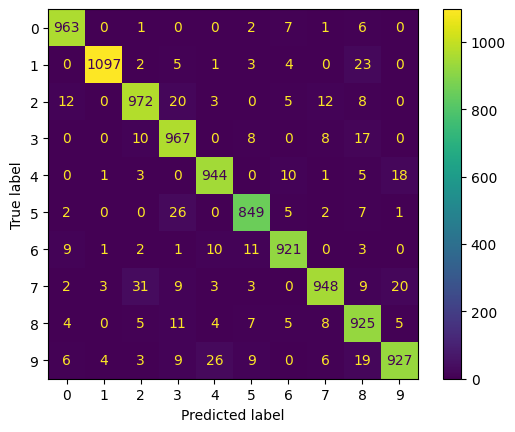

In [12]:
confusionMatrix(net, get_data, {
    "batch_size" : 128,
    "test_batch_size" : 256
})

- $9$ is frequently confused with $4$ because of the shape of both number which can look the same at a first glance.
- $8$ is frequently confused with 3 too because of their inherent shape.

In order to improve the accuracy of our model, it is important to add more images with various shapes and to regularize our models correctly.

The LeNet5 architecture can also be implemented using the sequential API ([see documentation](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html)). Reimplement it with this API.

## Experiments

* Implement adaptive early stopping: if the validation loss did not decrease for K consecutive epochs, stop training.
* Change dataset in order to evaluate the LeNet5 network on cifar10 dataset. You can have a look at the pytorch documentation to easily access the cifar10 dataset.
* Try to improve performance with:
   *   data-augmentation
   *   dropout
* Implement the resnet18 architecture using the Resnet18 class from pytorch.


### Early Stopping implementation:

Here we implement early stopping, if in the next $K$ epochs, the validation loss does not decrease from its minimal value, we stop the training to avoid overfitting.

In [13]:
def mainEarlyStopping(
        net,
        batch_size=128,
        device=device,
        learning_rate=0.01,
        weight_decay=0.00001,
        momentum=0.9,
        epochs=50,
        patience = 5):
  
  net.to(device)

  train_loader, val_loader, test_loader = get_data(batch_size)

  # TODO for defining LeNet-5 and moving it to the GPU

  optimizer = get_optimizer(net, learning_rate, weight_decay, momentum)

  cost_function = get_cost_function()

  print('Before training:')
  train_loss, train_accuracy = test(net, train_loader, cost_function)
  val_loss, val_accuracy = test(net, val_loader, cost_function)
  test_loss, test_accuracy = test(net, test_loader, cost_function)
  best_val_loss = float('inf')
  earlyStoppingCounter = 0
  print('\t Training loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
  print('\t Validation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss, val_accuracy))
  print('\t Test loss {:.5f}, Test accuracy {:.2f}'.format(test_loss, test_accuracy))
  print('-----------------------------------------------------')

  for e in range(epochs):
    train_loss, train_accuracy = train(net, train_loader, optimizer, cost_function)
    val_loss, val_accuracy = test(net, val_loader, cost_function)
    
    if val_loss < best_val_loss:
      best_val_loss = val_loss
      earlyStoppingCounter = 0
    else :
      earlyStoppingCounter +=1
    
    if earlyStoppingCounter >= patience:
      print("Out of patience, stopping the training !")
      print("---------------------------------------------------")
      break
        
    print('Epoch: {:d}'.format(e+1))
    print('\t Training loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
    print('\t Validation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss, val_accuracy))
    print('-----------------------------------------------------')

  print('After training:')
  train_loss, train_accuracy = test(net, train_loader, cost_function)
  val_loss, val_accuracy = test(net, val_loader, cost_function)
  test_loss, test_accuracy = test(net, test_loader, cost_function)

  print('\t Training loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
  print('\t Validation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss, val_accuracy))
  print('\t Test loss {:.5f}, Test accuracy {:.2f}'.format(test_loss, test_accuracy))
  print('-----------------------------------------------------')

In [14]:
netEarlyStopping = LeNet()

In [15]:
try : 
    mainEarlyStopping(net = netEarlyStopping)
except KeyboardInterrupt:
    print("Tired of training! Stop!")

Before training:
	 Training loss 0.01807, Training accuracy 9.84
	 Validation loss 0.00908, Validation accuracy 9.61
	 Test loss 0.00923, Test accuracy 10.28
-----------------------------------------------------
Epoch: 1
	 Training loss 0.00987, Training accuracy 59.60
	 Validation loss 0.00075, Validation accuracy 94.15
-----------------------------------------------------
Tired of training! Stop!


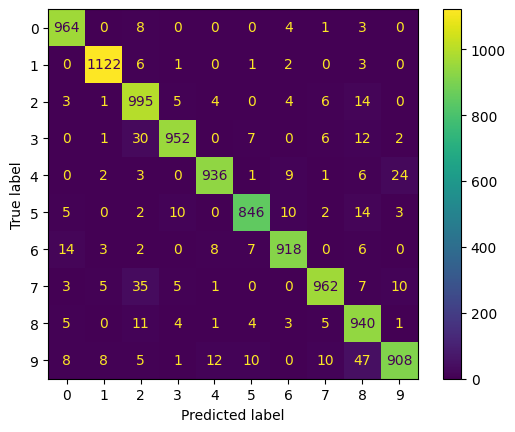

In [16]:
confusionMatrix(netEarlyStopping, get_data, {
    "batch_size" : 128,
    "test_batch_size" : 256
})

### Training LeNet5 on Cifar Dataset

Here we use a more complex data set, the CIFAR dataset, which adds RGB images and different labels from the classic MNIST ones.

In [17]:
def get_data_cifar10(batch_size, test_batch_size=256):

  # Prepare data transformations and then combine them sequentially
  transform = list()
  transform.append(T.ToTensor())                            # converts Numpy to Pytorch Tensor
  transform.append(T.Normalize(mean=[0.5], std=[0.5]))      # Normalizes the Tensors between [-1, 1]
  transform = T.Compose(transform)                          # Composes the above transformations into one.

  # Load data
  full_training_data = torchvision.datasets.CIFAR10('./data', train=True, transform=transform, download=True)
  test_data = torchvision.datasets.CIFAR10('./data', train=False, transform=transform, download=True)


  # Create train and validation splits
  num_samples = len(full_training_data)
  training_samples = int(num_samples*0.5+1)
  validation_samples = num_samples - training_samples

  training_data, validation_data = torch.utils.data.random_split(full_training_data, [training_samples, validation_samples])

  # Initialize dataloaders
  train_loader = torch.utils.data.DataLoader(training_data, batch_size, shuffle=True)
  val_loader = torch.utils.data.DataLoader(validation_data, test_batch_size, shuffle=False)
  test_loader = torch.utils.data.DataLoader(test_data, test_batch_size, shuffle=False)

  return train_loader, val_loader, test_loader

In order to train our models, we should first change the number of input channels!

In [18]:
class LeNetCIFAR(torch.nn.Module):
    
    def __init__(self):

        super(LeNetCIFAR, self).__init__()

        self.conv_1 = torch.nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1, device=device)
        self.conv_2 = torch.nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, device=device)

        
        self.connected_1 = torch.nn.Linear(in_features=400, out_features=120, device=device)
        self.connected_2 = torch.nn.Linear(in_features=120, out_features=84, device=device)
        self.connected_3 = torch.nn.Linear(in_features=84, out_features=10, device=device)

    def forward(self, x):

        x = self.conv_1(x)                        
        x = torch.nn.functional.relu(x)
        x = torch.nn.functional.max_pool2d(x, 2)  

        x = self.conv_2(x)                        
        x = torch.nn.functional.relu(x)
        x = torch.nn.functional.max_pool2d(x, 2)  

        x = x.view(x.shape[0], -1)                

        x = self.connected_1(x)
        x = torch.nn.functional.relu(x)

        x = self.connected_2(x)
        x = torch.nn.functional.relu(x)
        
        x = self.connected_3(x)

        x = F.log_softmax(x, dim=1)
        return x

In [19]:
def mainCIFAR(
        net,
        batch_size=128,
        device=device,
        learning_rate=0.01,
        weight_decay=0.00001,
        momentum=0.9,
        epochs=50,
        patience = 5):
  
  net.to(device)

  train_loader, val_loader, test_loader = get_data_cifar10(batch_size)

  # TODO for defining LeNet-5 and moving it to the GPU

  optimizer = get_optimizer(net, learning_rate, weight_decay, momentum)

  cost_function = get_cost_function()

  print('Before training:')
  train_loss, train_accuracy = test(net, train_loader, cost_function)
  val_loss, val_accuracy = test(net, val_loader, cost_function)
  test_loss, test_accuracy = test(net, test_loader, cost_function)
  best_val_loss = float('inf')
  earlyStoppingCounter = 0
  print('\t Training loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
  print('\t Validation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss, val_accuracy))
  print('\t Test loss {:.5f}, Test accuracy {:.2f}'.format(test_loss, test_accuracy))
  print('-----------------------------------------------------')

  for e in range(epochs):
    train_loss, train_accuracy = train(net, train_loader, optimizer, cost_function)
    val_loss, val_accuracy = test(net, val_loader, cost_function)
    if val_loss < best_val_loss:
      best_val_loss = val_loss
      earlyStoppingCounter = 0
    else :
      earlyStoppingCounter +=1
    
    if earlyStoppingCounter >= patience:
      print("Out of patience, stopping the training !")
      print("---------------------------------------------------")
      break
        
    print('Epoch: {:d}'.format(e+1))
    print('\t Training loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
    print('\t Validation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss, val_accuracy))
    print('-----------------------------------------------------')

  print('After training:')
  train_loss, train_accuracy = test(net, train_loader, cost_function)
  val_loss, val_accuracy = test(net, val_loader, cost_function)
  test_loss, test_accuracy = test(net, test_loader, cost_function)

  print('\t Training loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
  print('\t Validation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss, val_accuracy))
  print('\t Test loss {:.5f}, Test accuracy {:.2f}'.format(test_loss, test_accuracy))
  print('-----------------------------------------------------')

In [20]:
netCIFAR = LeNetCIFAR()

In [21]:
try :
    mainCIFAR(netCIFAR)
except KeyboardInterrupt:
    print("Tired of tranining! Stop!")

Before training:
	 Training loss 0.01807, Training accuracy 9.87
	 Validation loss 0.00904, Validation accuracy 10.12
	 Test loss 0.00923, Test accuracy 10.00
-----------------------------------------------------
Epoch: 1
	 Training loss 0.01801, Training accuracy 11.49
	 Validation loss 0.00892, Validation accuracy 12.45
-----------------------------------------------------
Tired of tranining! Stop!


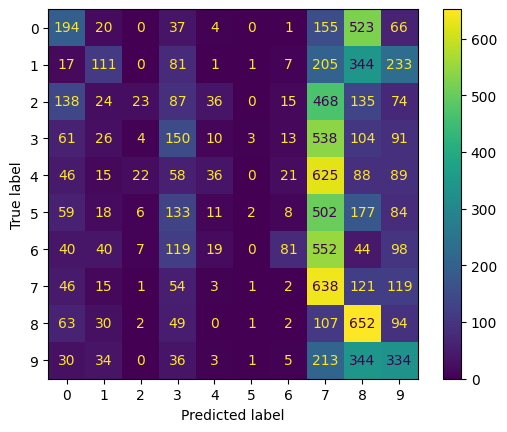

In [22]:
confusionMatrix(netCIFAR, get_data_cifar10, {
    "batch_size" : 128,
    "test_batch_size" : 256
})

As we can see, the results are not the best! This is because of the complexity of the dataset and the architecture of our model which is not enough for this difficult training set. 

We often confuse the truck with the car and the cat with the dog!

### Dropout

To improve our regularization, we add to our model $\text{Dropout}$, which kills neuronnes in order to avoid overfitting. We take as $\text{drop}$ probability, $p = 0.2$.

In [23]:
class LeNetImproved(torch.nn.Module):
    
    def __init__(self):

        super(LeNetImproved, self).__init__()

        self.droput = torch.nn.Dropout(0.2)
        
        self.conv_1 = torch.nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding = 2, device=device)
        self.conv_2 = torch.nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, device=device)

        self.connected_1 = torch.nn.Linear(in_features=400, out_features=120, device=device)
        self.connected_2 = torch.nn.Linear(in_features=120, out_features=84, device=device)
        self.connected_3 = torch.nn.Linear(in_features=84, out_features=10, device=device)

    def forward(self, x):
        
        x = self.droput(x)
        x = self.conv_1(x)                        
        x = torch.nn.functional.relu(x)
        x = torch.nn.functional.max_pool2d(x, 2)  

        x = self.droput(x)
        x = self.conv_2(x)                        
        x = torch.nn.functional.relu(x)
        x = torch.nn.functional.max_pool2d(x, 2)  

        x = x.view(x.shape[0], -1)                

        x = self.droput(x)
        x = self.connected_1(x)
        x = torch.nn.functional.relu(x)

        x = self.droput(x)
        x = self.connected_2(x)
        x = torch.nn.functional.relu(x)

        x = self.droput(x)    
        x = self.connected_3(x)

        x = F.log_softmax(x, dim=1)
        return x


In [24]:
netDropout = LeNetImproved()

In [ ]:
try:
    mainEarlyStopping(net = netDropout)
except KeyboardInterrupt:
    print("Tired of training! Stop!")

Before training:
	 Training loss 0.01804, Training accuracy 7.83
	 Validation loss 0.00906, Validation accuracy 7.90
	 Test loss 0.00922, Test accuracy 7.78
-----------------------------------------------------
Epoch: 1
	 Training loss 0.01268, Training accuracy 42.40
	 Validation loss 0.00135, Validation accuracy 90.60
-----------------------------------------------------
Epoch: 2
	 Training loss 0.00269, Training accuracy 89.10
	 Validation loss 0.00053, Validation accuracy 96.13
-----------------------------------------------------
Epoch: 3
	 Training loss 0.00169, Training accuracy 93.24
	 Validation loss 0.00040, Validation accuracy 96.94
-----------------------------------------------------
Epoch: 4
	 Training loss 0.00140, Training accuracy 94.62
	 Validation loss 0.00033, Validation accuracy 97.33
-----------------------------------------------------
Epoch: 5
	 Training loss 0.00125, Training accuracy 95.09
	 Validation loss 0.00032, Validation accuracy 97.50
------------------

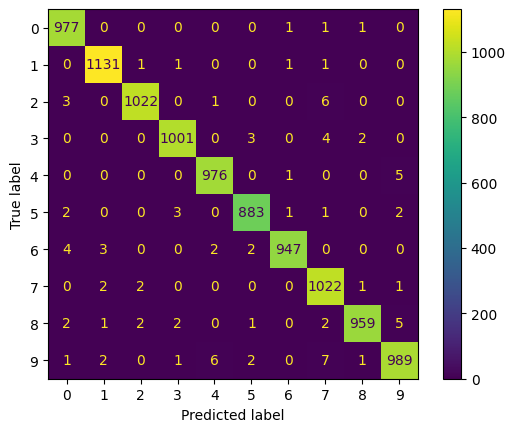

In [ ]:
confusionMatrix(netDropout, get_data, {
    "batch_size" : 128,
    "test_batch_size" : 256
})

### Data Augmentation

In order to improve our results, we need to augment the data so the CNN learns from all different kinds of transformations.

This funciton below, applies various transformation to either the $\text{MNIST}$ or the $\text{CIFAR10}$ data set, according to the user's input.

First, let us adapt the previous NN with dropout for $3$ channels.

In [ ]:
class LeNetImprovedCIFAR(torch.nn.Module):
    
    def __init__(self):

        super(LeNetImprovedCIFAR, self).__init__()

        self.droput = torch.nn.Dropout(0.2)
        
        self.conv_1 = torch.nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1, device=device)
        self.conv_2 = torch.nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, device=device)

        self.connected_1 = torch.nn.Linear(in_features=400, out_features=120, device=device)
        self.connected_2 = torch.nn.Linear(in_features=120, out_features=84, device=device)
        self.connected_3 = torch.nn.Linear(in_features=84, out_features=10, device=device)

    def forward(self, x):
        
        x = self.droput(x)
        x = self.conv_1(x)                        
        x = torch.nn.functional.relu(x)
        x = torch.nn.functional.max_pool2d(x, 2)  

        x = self.droput(x)
        x = self.conv_2(x)                        
        x = torch.nn.functional.relu(x)
        x = torch.nn.functional.max_pool2d(x, 2)  

        x = x.view(x.shape[0], -1)                

        x = self.droput(x)
        x = self.connected_1(x)
        x = torch.nn.functional.relu(x)

        x = self.droput(x)
        x = self.connected_2(x)
        x = torch.nn.functional.relu(x)

        x = self.droput(x)    
        x = self.connected_3(x)

        x = F.log_softmax(x, dim=1)
        return x


In [ ]:
def get_data_augmented(batch_size, test_batch_size=256, data = 'MNIST'):

  # Prepare data transformations and then combine them sequentially
    transform_augmented = list()
    transform_augmented.append(T.ToTensor())                            # converts Numpy to Pytorch Tensor
    transform_augmented.append(T.Normalize(mean=[0.5], std=[0.5]))      # Normalizes the Tensors between [-1, 1]
    transform_augmented.append(T.RandomRotation(degrees=60))            # Random Rotation
    transform_augmented.append(T.RandomGrayscale(p = 0.1))              # Random Grayscale
    transform_augmented.append(T.RandomAffine(degrees=0, translate=(0.1, 0.1))) # Random Affine Transformation
    transform_augmented = T.Compose(transform_augmented)                         # Composes the above transformations into one.

    transform = list()
    transform.append(T.ToTensor())                            # converts Numpy to Pytorch Tensor
    transform.append(T.Normalize(mean=[0.5], std=[0.5]))      # Normalizes the Tensors between [-1, 1]
    transform = T.Compose(transform)                          # Composes the above transformations into one.    

  # Load data
    if data != 'MNIST' and data != 'CIFAR10':
        raise Exception("Please Choose either CIFAR10 or MNIST as inputs!")
    
    if data == 'MNIST':
      full_training_data = torchvision.datasets.MNIST('./data', train=True, transform=transform_augmented, download=True)
      test_data = torchvision.datasets.MNIST('./data', train=False, transform=transform, download=True)

    else :

      full_training_data = torchvision.datasets.CIFAR10('./data', train=True, transform=transform_augmented, download=True)
      test_data = torchvision.datasets.CIFAR10('./data', train=False, transform=transform, download=True)

  # Create train and validation splits
    num_samples = len(full_training_data)
    training_samples = int(num_samples*0.5+1)
    validation_samples = num_samples - training_samples

    training_data, validation_data = torch.utils.data.random_split(full_training_data, [training_samples, validation_samples])

  # Initialize dataloaders
    train_loader = torch.utils.data.DataLoader(training_data, batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(validation_data, test_batch_size, shuffle=False)
    test_loader = torch.utils.data.DataLoader(test_data, test_batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

In [ ]:
def mainAugmented(
        net,
        data = 'MNIST',
        batch_size=128,
        device=device,
        learning_rate=0.01,
        weight_decay=0.00001,
        momentum=0.9,
        epochs=50,
        patience = 5):

  net.to(device)

  train_loader, val_loader, test_loader = get_data_augmented(batch_size, data=data)

  # TODO for defining LeNet-5 and moving it to the GPU

  optimizer = get_optimizer(net, learning_rate, weight_decay, momentum)

  cost_function = get_cost_function()

  print('Before training:')
  train_loss, train_accuracy = test(net, train_loader, cost_function)
  val_loss, val_accuracy = test(net, val_loader, cost_function)
  test_loss, test_accuracy = test(net, test_loader, cost_function)
  best_val_loss = float('inf')
  earlyStoppingCounter = 0
  print('\t Training loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
  print('\t Validation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss, val_accuracy))
  print('\t Test loss {:.5f}, Test accuracy {:.2f}'.format(test_loss, test_accuracy))
  print('-----------------------------------------------------')

  for e in range(epochs):
    train_loss, train_accuracy = train(net, train_loader, optimizer, cost_function)
    val_loss, val_accuracy = test(net, val_loader, cost_function)
    if val_loss < best_val_loss:
      best_val_loss = val_loss
      earlyStoppingCounter = 0
    else :
      earlyStoppingCounter +=1
    
    if earlyStoppingCounter >= patience:
      break
        
    print('Epoch: {:d}'.format(e+1))
    print('\t Training loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
    print('\t Validation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss, val_accuracy))
    print('-----------------------------------------------------')

  print('After training:')
  train_loss, train_accuracy = test(net, train_loader, cost_function)
  val_loss, val_accuracy = test(net, val_loader, cost_function)
  test_loss, test_accuracy = test(net, test_loader, cost_function)

  print('\t Training loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
  print('\t Validation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss, val_accuracy))
  print('\t Test loss {:.5f}, Test accuracy {:.2f}'.format(test_loss, test_accuracy))
  print('-----------------------------------------------------')

The training takes a $\text{loooooooooooooooooong}$ time! So sit back and watch the validation loss decrease!

In [ ]:
netAugmentedDataSet = LeNetImprovedCIFAR().to(device)

In [ ]:
try:
    mainAugmented(netAugmentedDataSet, data='CIFAR10', epochs=70)
except KeyboardInterrupt:
    print("Tired of Traning! Stop!")

Before training:
	 Training loss 0.01807, Training accuracy 9.81
	 Validation loss 0.00904, Validation accuracy 9.96
	 Test loss 0.00922, Test accuracy 10.10
-----------------------------------------------------
Epoch: 1
	 Training loss 0.01766, Training accuracy 14.16
	 Validation loss 0.00833, Validation accuracy 19.44
-----------------------------------------------------
Epoch: 2
	 Training loss 0.01630, Training accuracy 22.02
	 Validation loss 0.00791, Validation accuracy 25.55
-----------------------------------------------------
Epoch: 3
	 Training loss 0.01563, Training accuracy 26.37
	 Validation loss 0.00768, Validation accuracy 28.59
-----------------------------------------------------
Epoch: 4
	 Training loss 0.01498, Training accuracy 29.90
	 Validation loss 0.00750, Validation accuracy 30.57
-----------------------------------------------------
Epoch: 5
	 Training loss 0.01468, Training accuracy 31.79
	 Validation loss 0.00726, Validation accuracy 32.62
-----------------

KeyboardInterrupt: 

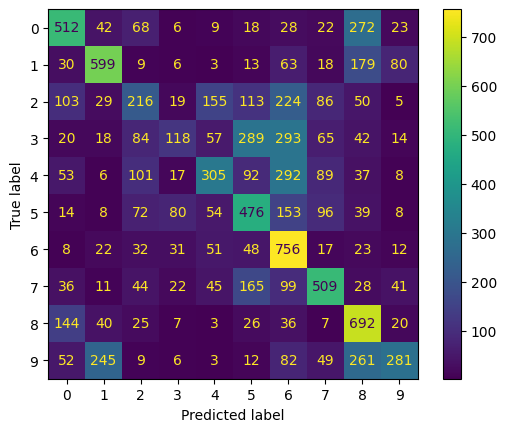

In [ ]:
confusionMatrix(netAugmentedDataSet, get_data_cifar10, {
    "batch_size" : 128,
    "test_batch_size" : 256,
})

### Resnet18 architecture

We can also use the $\text{ResNet18}$ architecture, which adds more layers and improves the results of the CNN. Let us import it from the $\text{torch}$ library.

In [ ]:
resNet = torchvision.models.resnet18().to(device)

In [ ]:
try :
    mainAugmented(net = resNet, patience=5, data='CIFAR10', epochs=70)
except KeyboardInterrupt:
    print("Tired of tranining! Stop!")

Before training:
	 Training loss 0.05430, Training accuracy 0.00
	 Validation loss 0.02717, Validation accuracy 0.00
	 Test loss 0.02771, Test accuracy 0.01
-----------------------------------------------------
Epoch: 1
	 Training loss 0.01589, Training accuracy 31.05
	 Validation loss 0.00676, Validation accuracy 36.91
-----------------------------------------------------
Epoch: 2
	 Training loss 0.01322, Training accuracy 39.34
	 Validation loss 0.00670, Validation accuracy 39.94
-----------------------------------------------------
Epoch: 3
	 Training loss 0.01231, Training accuracy 43.58
	 Validation loss 0.00605, Validation accuracy 44.68
-----------------------------------------------------
Epoch: 4
	 Training loss 0.01170, Training accuracy 46.78
	 Validation loss 0.00599, Validation accuracy 45.68
-----------------------------------------------------
Epoch: 5
	 Training loss 0.01121, Training accuracy 49.48
	 Validation loss 0.00569, Validation accuracy 47.98
------------------

KeyboardInterrupt: 

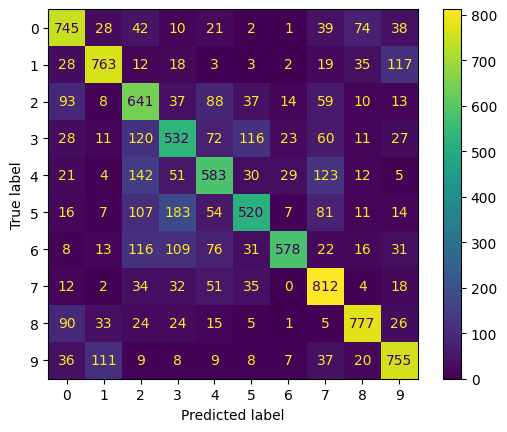

In [ ]:
confusionMatrix(resNet, get_data_cifar10, {
    "batch_size" : 128,
    "test_batch_size" : 256,
})